Import necessary libraries

In [1]:
# imports
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import pandas as pd
import random




In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/ai2/data/synthetic_control.data'
data = pd.read_csv(data_path, delim_whitespace=True, header=None)

<ipython-input-3-4196c1629937>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(data_path, delim_whitespace=True, header=None)


In [4]:
import numpy as np
import random

def prep_data():
  """ Preps data to X and Y and mixes them together """

  X = data.values.tolist()
  y = np.array(np.repeat(np.arange(6), 100))

  X_and_y = list(zip(X, y))
  random.seed(42)
  random.shuffle(X_and_y)

  X, y = zip(*X_and_y)

  X = np.array(X)
  y = np.array(y)

  # check that data is actually mixed - could fail if mixing results randomly
  # in sorted order, but that is very unlikely
  assert X_and_y != sorted(X_and_y, key=lambda x: x[1]), "mix (maybe) not ok, double check"

  return X, y


Training model: Basic_CNN
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Basic_CNN - Test Accuracy: 0.9583
Training model: Deeper_CNN
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Deeper_CNN - Test Accuracy: 0.9792
Training model: CNN_with_Dropout


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
CNN_with_Dropout - Test Accuracy: 0.9792
Training model: CNN_with_GlobalAvgPool


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
CNN_with_GlobalAvgPool - Test Accuracy: 0.9417
Training model: Hybrid_CNN_LSTM
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Hybrid_CNN_LSTM - Test Accuracy: 0.9875

Test accuracy overview:
Basic_CNN: 0.9583
Deeper_CNN: 0.9792
CNN_with_Dropout: 0.9792
CNN_with_GlobalAvgPool: 0.9417
Hybrid_CNN_LSTM: 0.9875


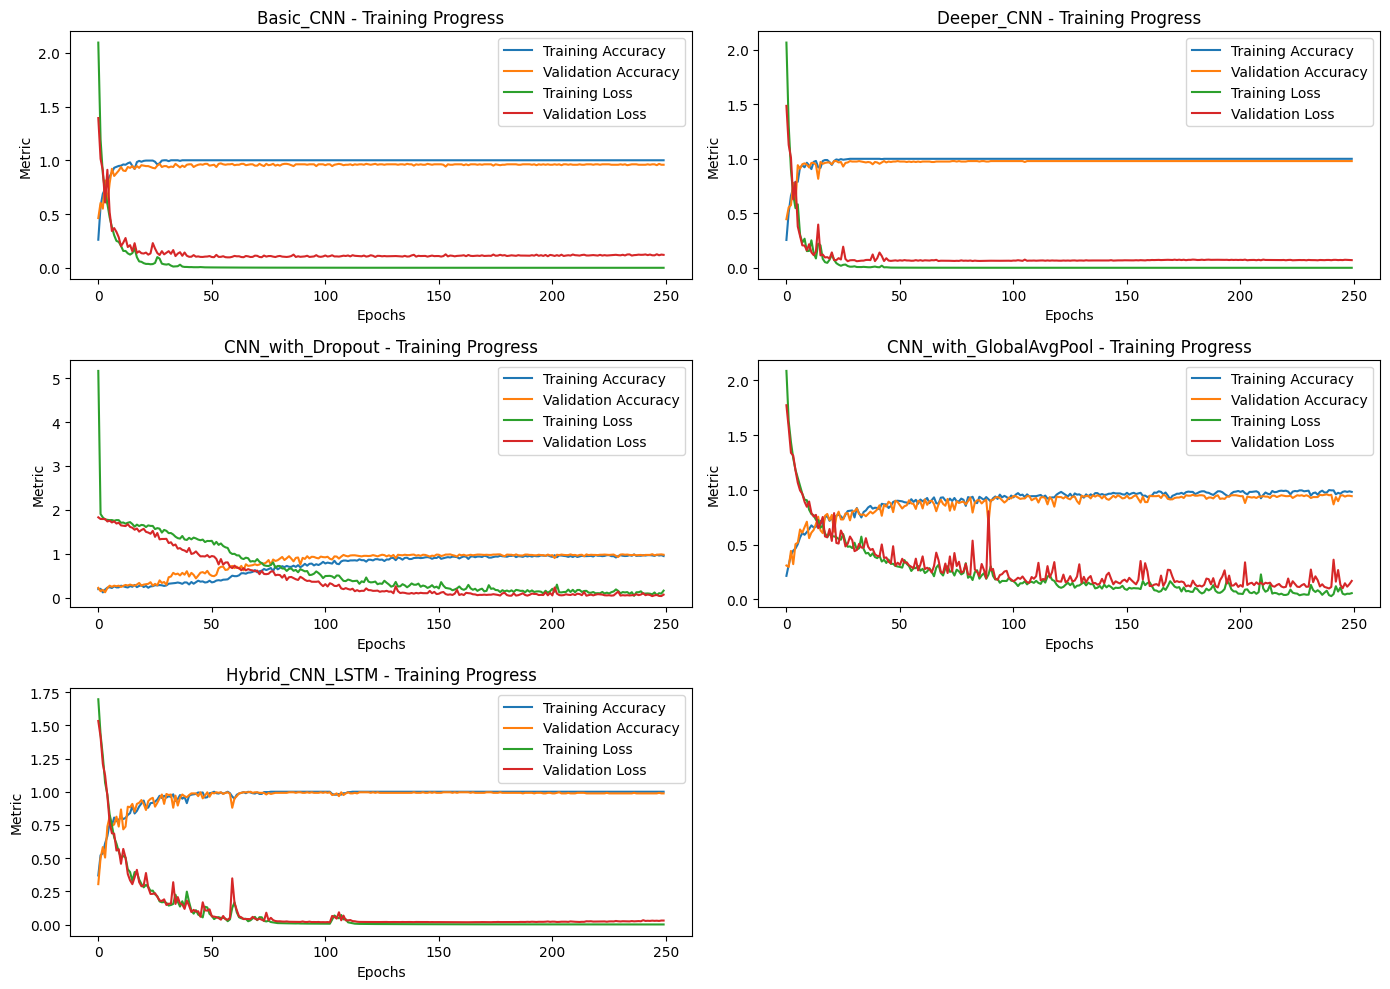

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# list of model architectures
models = []
time_steps=60
n_classes = 6

# model 0: basic convolutional network
models.append(("Basic_CNN", Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(n_classes, activation='softmax')
])))

# model 1: basic deeper convolutional network
models.append(("Deeper_CNN", Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(n_classes, activation='softmax')
])))

# model 2: CNN with Dropout layers
models.append(("CNN_with_Dropout", Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])))

# model 3: CNN with Global Average Pooling
models.append(("CNN_with_GlobalAvgPool", Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(),
    Dense(50, activation='relu'),
    Dense(n_classes, activation='softmax')
])))

# model 4: Hybrid CNN-LSTM
models.append(("Hybrid_CNN_LSTM", Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False),
    Dense(n_classes, activation='softmax')
])))

# collecting training history and results for each model
histories = []
accuracies = []
losses = []
misclassified_samples = {}

# training and evaluating each model
for name, model in models:
    print(f"Training model: {name}")
    X, y = prep_data()
    # splitting data into training and test sets
    X = np.array(X).reshape((len(X), time_steps, 1))
    y = to_categorical(np.array(y))  # converting target values to categories
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # train the model without printing training losses
    history = model.fit(X_train, y_train, epochs=250, batch_size=16, validation_data=(X_test, y_test), verbose=0)
    histories.append((name, history))

    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append((name, accuracy))
    losses.append((name, loss))

    # track misclassified samples
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    misclassified = [(i, y_pred_classes[i], y_true_classes[i]) for i in range(len(y_test)) if y_pred_classes[i] != y_true_classes[i]]
    misclassified_samples[name] = misclassified

    print(f"{name} - Test Accuracy: {accuracy:.4f}")

# displaying test accuracies for all models
print("\nTest accuracy overview:")
for name, accuracy in accuracies:
    print(f"{name}: {accuracy:.4f}")

# plotting training progress
plt.figure(figsize=(14, 10))
for i, (name, history) in enumerate(histories):
    plt.subplot(3, 2, i+1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{name} - Training Progress")
    plt.xlabel("Epochs")
    plt.ylabel("Metric")
    plt.legend()

plt.tight_layout()
plt.show()


In [7]:
# since we have 5 high accuracy models, lets try to assemble them to have stronger prediction

from scipy.stats import mode
from sklearn.metrics import accuracy_score


# prepare test data
X, y = prep_data()
X = np.array(X).reshape((len(X), time_steps, 1))
y = to_categorical(np.array(y))  # converting target values to categories
_, X_test, _, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


# predict classes with each model and collect predictions
model_predictions = []

for name, model in models:
    y_pred = model.predict(X_test)
    model_predictions.append(np.argmax(y_pred, axis=1))

model_predictions = np.array(model_predictions)

# majority voting
ensemble_predictions, _ = mode(model_predictions, axis=0)
ensemble_predictions = ensemble_predictions.flatten()

# calculate ensemble accuracy
ensemble_accuracy = accuracy_score(y_true_classes, ensemble_predictions)
print(f"Ensemble Model - Test Accuracy: {ensemble_accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Ensemble Model - Test Accuracy: 0.9875


In [8]:
# now lest check the misclassified samples
misclassified_samples = [(index, pred, true)
                         for index, (pred, true) in enumerate(zip(ensemble_predictions, y_true_classes))
                         if pred != true]

print("\nMisclassified Samples:")
print("Index | Predicted | True")
for index, pred, true in misclassified_samples:
    print(f"{index:<6} | {pred:<9} | {true}")


Misclassified Samples:
Index | Predicted | True
31     | 0         | 2
48     | 5         | 3
228    | 5         | 3


In [11]:
_, X_test, _, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

ensemble_miss_samples = X_test[31], X_test[48], X_test[228]
ensemble_miss_indices = 31, 48, 228

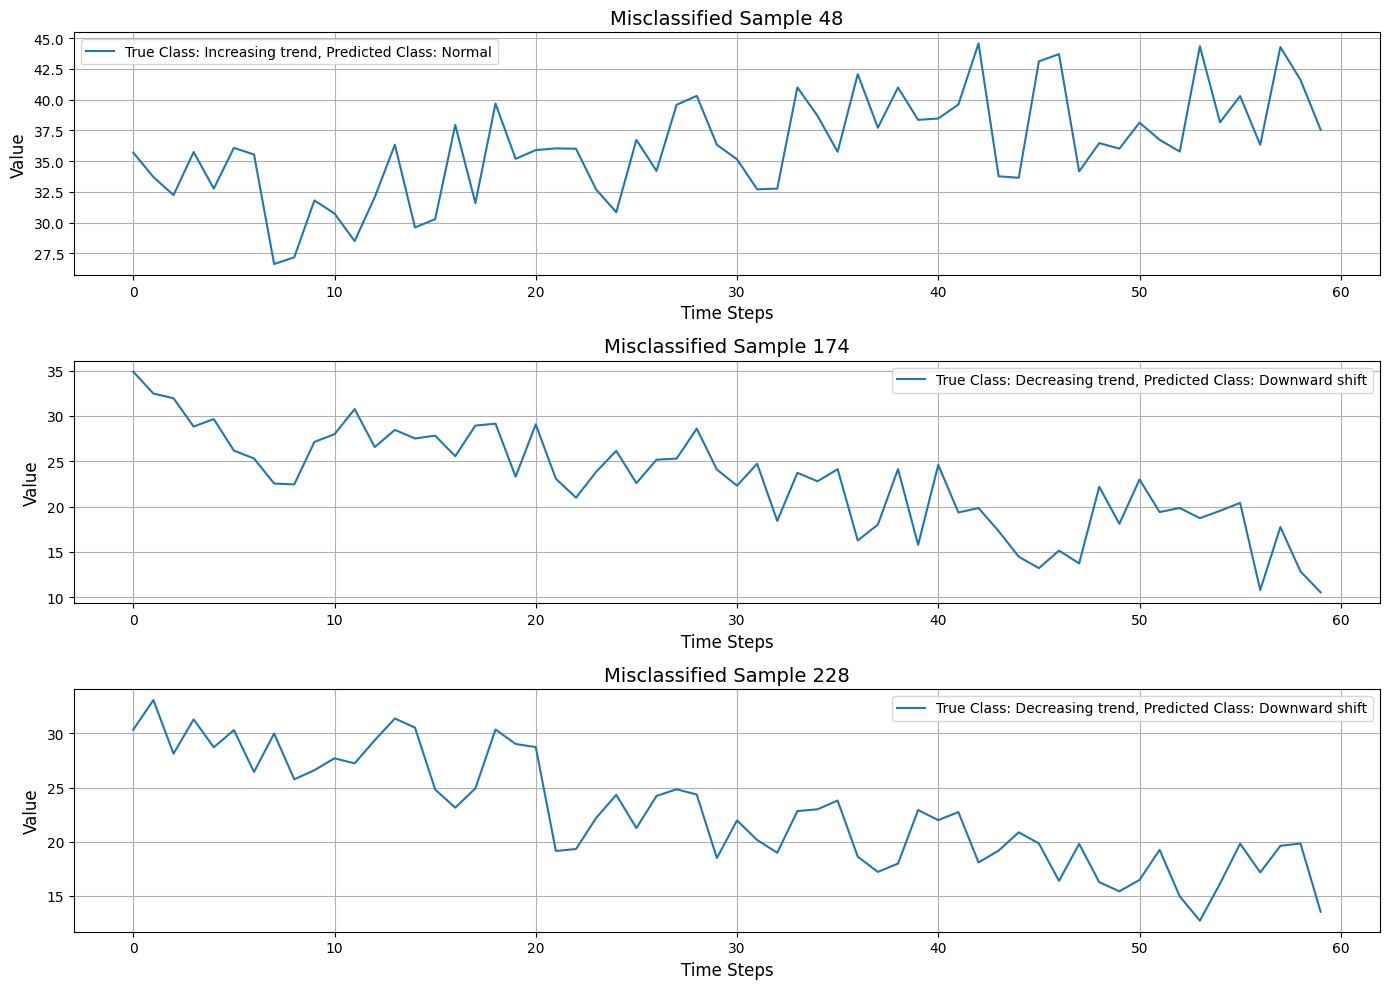

In [12]:
# visualize missclassified samples

import numpy as np
import matplotlib.pyplot as plt

ensemble_miss_samples = [X_test[i].flatten() for i in ensemble_miss_indices]
true_classes = ["Increasing trend", "Decreasing trend", "Decreasing trend"]
predicted_classes = ["Normal", "Downward shift", "Downward shift"]
ensemble_miss_indices = [48, 174, 228]

plt.figure(figsize=(14, 10))

for i, sample in enumerate(ensemble_miss_samples):
    plt.subplot(len(ensemble_miss_samples), 1, i + 1)
    plt.plot(sample, label=f'True Class: {true_classes[i]}, Predicted Class: {predicted_classes[i]}')
    plt.title(f'Misclassified Sample {ensemble_miss_indices[i]}', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
